# Compare Gurobi parameter BarConvTol
plot results of running tests on the parameter for the barrier method convergence tolerance (BarConvTol), which is the tolerence on (primal_obj - dual_obj)/dual_obj

In [75]:
import glob
import os

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import calliope
from calliope.core.util.dataset import split_loc_techs

In [ ]:
calliope.set_log_verbosity()

In [2]:
mpl.rcParams['text.latex.preamble'] = [
    #r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
    #r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
    r'\usepackage{helvet}',    # set the normal font here
    r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
    r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

/cluster/work/apatt/brynmorp/miniconda/envs/eurocalliope/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:

Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.



In [5]:
model_filenames = glob.glob("../outputs/barconvtol/*.nc")
model_dict = {
    os.path.basename(model_filename).split('.')[0]: calliope.read_netcdf(model_filename)._model_data 
    for model_filename in model_filenames
}
# Remove some parameters, otherwise concatenation will fail
scenario_model_data = xr.concat(model_dict.values(), dim=pd.Index(model_dict.keys(), name='scenario'))
neg_power = {i: int(i.split("-")[1]) for i in model_dict.keys()}

## Plot solution time and objective function value vs. tolerance

/cluster/work/apatt/brynmorp/miniconda/envs/eurocalliope/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



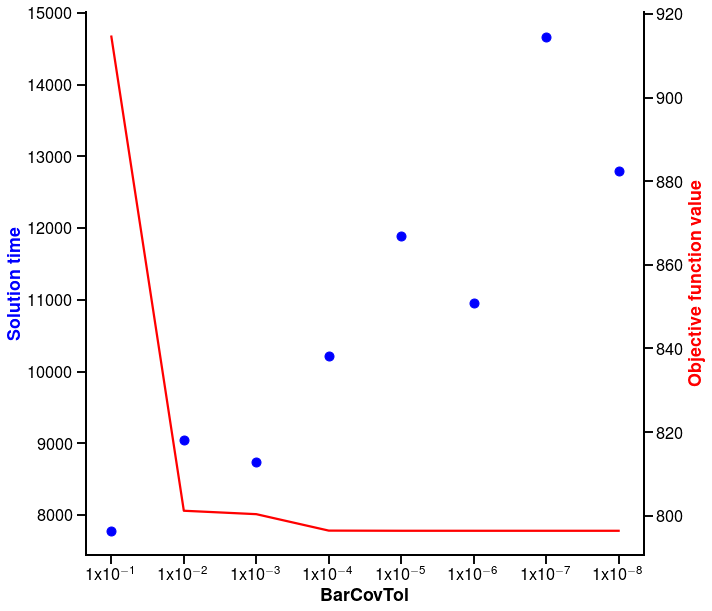

In [198]:
with sns.plotting_context("talk"):
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"]
    })
    sol_times = [model.attrs["solution_time"] for model in model_dict.values()]
    obj = [model.attrs["objective_function_value"] for model in model_dict.values()]
    df = pd.DataFrame(index=neg_power.values(), columns=['Solution time', 'Objective function value'], data=np.array([sol_times, obj]).T).sort_index()

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    secax = ax.twinx()

    ax.set_ylabel("\\textbf{Solution time}", c="blue")
    ax.set_xlabel("\\textbf{BarCovTol}")
    ax.set_xticklabels([0] + [f"1x10$^{{-{i}}}$" for i in df.index] + [9])
    secax.set_ylabel("\\textbf{Objective function value}", c="red")

    df.plot(y="Solution time", ax=ax, marker="o", linestyle="None", c="blue", legend=False)
    df.plot(y="Objective function value", ax=secax, c="red", legend=False)
    sns.despine(right=False)


## Look at how some key metrics behave

In [171]:
tech_groups = {
    'ac_ohl_mountain_transmission': 'transmission',
    'ac_ohl_transmission': 'transmission',
    'battery': 'storage',
    'dc_ohl_transmission': 'transmission',
    'dc_subsea_transmission': 'transmission',
    'dc_underground_transmission': 'transmission',
    'hydro_reservoir': 'hydro',
    'hydro_run_of_river': 'hydro',
    'hydrogen_storage': 'storage',
    'open_field_pv': 'pv',
    'pumped_hydro': 'storage',
    'methane_storage': 'storage',
    'roof_mounted_pv': 'pv',
    'wind_offshore': 'wind_off',
    'wind_onshore_competing': 'wind_on',
    'wind_onshore_monopoly': 'wind_on',
    'electrolysis': 'electrolysis',
    'biofuel_boiler': 'boiler',
    'methane_boiler': 'boiler',
    'electric_heater': 'electrified_heat',
    'hp': 'electrified_heat',
    'gas_hob': 'gas_cooking',
    'gas_hob': 'electrified_cooking',
    'waste_supply': 'waste_incineration',
    'ccgt': 'gas_powered_electricity',
    'heavy_transport_ev': 'EV transport',
    'heavy_transport_ice': 'ICE transport',
    'light_transport_ev': 'EV transport',
    'light_transport_ice': 'ICE transport',
    'biofuel_to_diesel': 'biofuel derived\nsynthetic fuel',
    'biofuel_to_liquids': 'biofuel derived\nsynthetic fuel',
    'biofuel_to_methane': 'biofuel derived\nsynthetic fuel',
    'hydrogen_to_diesel': 'hydrogen derived\nsynthetic fuel',
    'hydrogen_to_liquids': 'hydrogen derived\nsynthetic fuel',
    'hydrogen_to_methane': 'hydrogen derived\nsynthetic fuel'
}

df0 = split_loc_techs(scenario_model_data.energy_cap, return_as="Series").where(lambda x: ~np.isinf(x) & (x > 1e-4)).dropna().sum(level=['scenario', 'techs']).unstack('scenario')[["1e-4", "1e-5", "1e-6", "1e-7", "1e-8"]]
df0.index = df0.index.str.split(':', expand=True).rename(['techs', 'foo'])
df0 = df0.groupby(tech_groups, level='techs').sum(min_count=1).dropna(how='all')
df0_norm = df0.div(df0.max(axis=1), axis=0).stack().to_frame('Normalised Energy capacity').reset_index()

df1 = (
    scenario_model_data
    .systemwide_levelised_cost
    .to_series()
    .where(lambda x: ~np.isinf(x))
    .dropna()
    .droplevel('costs')
    .unstack('scenario')
    [["1e-4", "1e-5", "1e-6", "1e-7", "1e-8"]]
    .groupby(tech_groups, level='techs').mean()
    .rename_axis(index='techs')
    .reindex(df0.index)
    .dropna(how='all')
)
df1_norm = df1.div(df1.max(axis=1), axis=0).stack().to_frame('Normalised levelised cost').reset_index()

df2 = (
    scenario_model_data
    .systemwide_capacity_factor
    .to_series()
    .where(lambda x: ~np.isinf(x))
    .dropna()
    .unstack('scenario')
    [["1e-4", "1e-5", "1e-6", "1e-7", "1e-8"]]
    .groupby(tech_groups, level='techs').mean()
    .rename_axis(index='techs')
    .reindex(df0.index)
    .dropna(how='all')
)
df2_norm = df2.div(df2.max(axis=1), axis=0).stack().to_frame('Normalised capacity factor').reset_index()

/cluster/work/apatt/brynmorp/miniconda/envs/eurocalliope/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator

/cluster/work/apatt/brynmorp/miniconda/envs/eurocalliope/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator

/cluster/work/apatt/brynmorp/miniconda/envs/eurocalliope/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



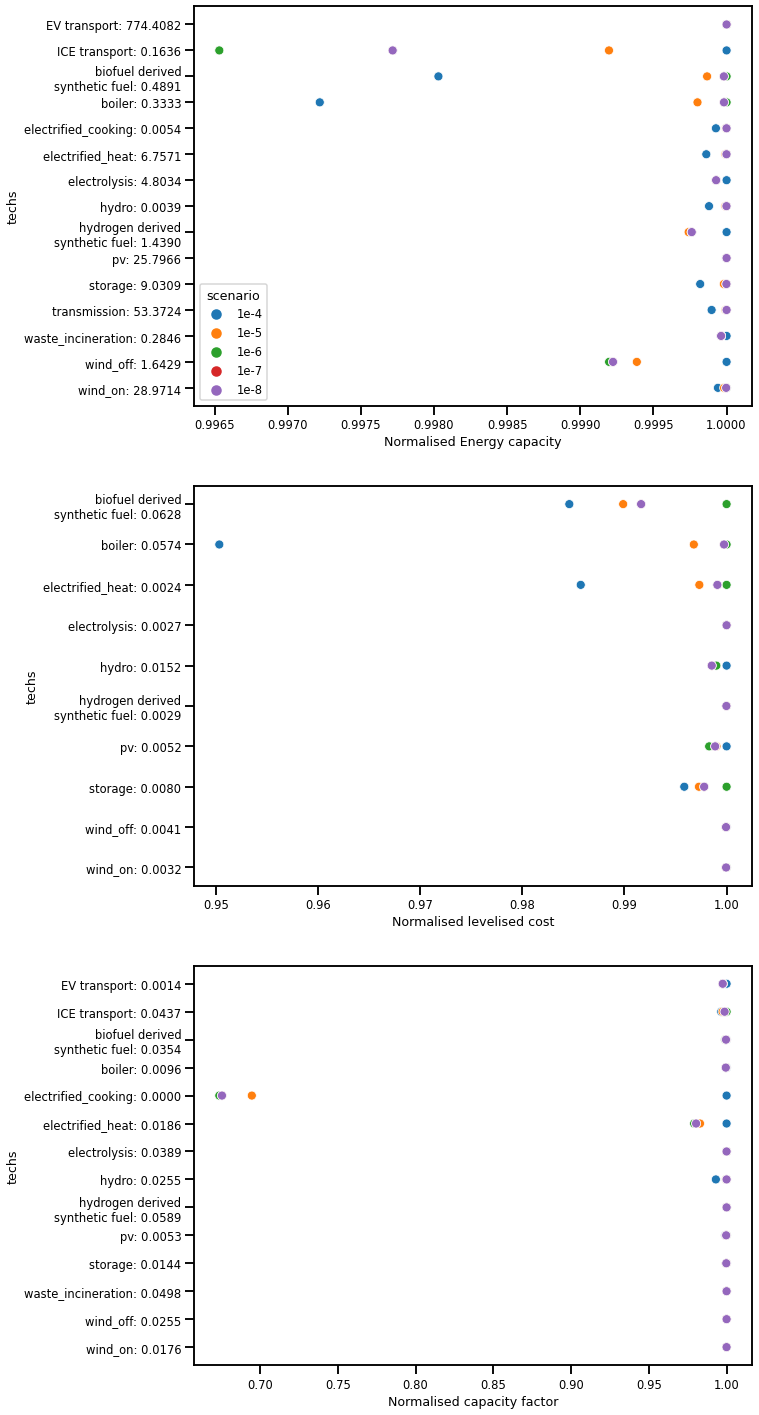

In [195]:
with sns.plotting_context("talk", font_scale=0.7):
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"]
    })
    fig, ax = plt.subplots(3, 1, figsize=(10, 25))
    sns.scatterplot(data=df0_norm, y='techs', x='Normalised Energy capacity', hue='scenario', ax=ax[0])
    ax[0].set_yticklabels([f"{i}: {df0.loc[i].max():.4f}" for i in df0.index])

    sns.scatterplot(data=df1_norm, y='techs', x='Normalised levelised cost', hue='scenario', ax=ax[1], legend=False)
    ax[1].set_yticklabels([f"{i}: {df1.loc[i].mean():.4f}" for i in df1.index])
    
    sns.scatterplot(data=df2_norm, y='techs', x='Normalised capacity factor', hue='scenario', ax=ax[2], legend=False)
    ax[2].set_yticklabels([f"{i}: {df2.loc[i].mean():.4f}" for i in df2.index])